In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense

data_size = 2000
target_column_index = 3

In [79]:
df = pd.read_csv('..\Data\eurusd_hour.csv', delimiter=',')
df = df.iloc[:data_size, :]
dates = pd.to_datetime(df['Date'] + ' ' + df['Time'])
scaler = MinMaxScaler(feature_range=(0, 1))
df.drop(columns=['Date', 'Time'], inplace=True)
df.index = dates
scaled_data = scaler.fit_transform(df)
print(scaled_data[:10, :])
print(df.head())

[[0.8867152  0.87607808 0.88237965 0.87783833 0.49610078 0.88717015
  0.876532   0.88283379 0.87829246 0.50790861]
 [0.87943585 0.87244666 0.88147139 0.8760218  0.53209358 0.87989081
  0.87290059 0.88192552 0.87647593 0.543058  ]
 [0.87852593 0.87789378 0.88328792 0.88419619 0.59208158 0.87898089
  0.87834771 0.88374205 0.88465032 0.6016403 ]
 [0.88580528 0.88243305 0.89146231 0.88419619 0.54409118 0.88626024
  0.88288697 0.89191644 0.88465032 0.55477446]
 [0.8867152  0.88243305 0.89055404 0.88782925 0.56208758 0.88717015
  0.88288697 0.89100817 0.88828338 0.57234915]
 [0.88853503 0.88152519 0.8941871  0.88692098 0.54409118 0.88898999
  0.88197912 0.89464124 0.88737511 0.55477446]
 [0.88853503 0.8833409  0.89327884 0.89100817 0.57108578 0.88898999
  0.88379483 0.89373297 0.89100817 0.57820738]
 [0.89262966 0.88379483 0.8928247  0.88828338 0.52609478 0.89262966
  0.88379483 0.8928247  0.88828338 0.53719977]
 [0.88989991 0.8901498  0.89645777 0.89600363 0.59508098 0.88989991
  0.8901498 

In [112]:
# def create_dataset(data: np.ndarray, time_step: int=10):
#     feature_number = data.shape[1]
#     Y = []
#     X = np.full((len(range(time_step, len(data) - 1)), time_step, feature_number), np.nan, dtype=float)
#     print(X.shape)
#     for i in range(time_step, len(data) - 1):
#         window = data[i - time_step : i, 0]

#         X[i - time_step, :, 0] = window.flatten()

#         Y.append(data[i, 0])
        
#     return X, np.array(Y, dtype=float).reshape(-1, 1), feature_number, time_step

def create_dataset(data: np.ndarray, time_step: int=10):
    X, Y = [], []
    for i in range(len(data) - time_step):
        # Define the range of input sequences
        end_ix = i + time_step
        
        # Define the range of output sequences
        out_end_ix = end_ix + 1
        
        # Ensure that the dataset is within bounds
        if out_end_ix > len(data)-1:
            break
            
        # Extract input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[out_end_ix]
        
        # Append the parts
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y), feature_number, time_step


X, Y, feature_number, time_step = create_dataset(data=scaled_data)

print(type(X), type(Y), feature_number, time_step, sep=' ')
print(X.shape, Y.shape)
print(f"X:\n{X[:1, :]=}\nY:\n{Y[:1]=}")

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 10 10
(1989, 10, 10) (1989, 10)
X:
X[:1, :]=array([[[0.8867152 , 0.87607808, 0.88237965, 0.87783833, 0.49610078,
         0.88717015, 0.876532  , 0.88283379, 0.87829246, 0.50790861],
        [0.87943585, 0.87244666, 0.88147139, 0.8760218 , 0.53209358,
         0.87989081, 0.87290059, 0.88192552, 0.87647593, 0.543058  ],
        [0.87852593, 0.87789378, 0.88328792, 0.88419619, 0.59208158,
         0.87898089, 0.87834771, 0.88374205, 0.88465032, 0.6016403 ],
        [0.88580528, 0.88243305, 0.89146231, 0.88419619, 0.54409118,
         0.88626024, 0.88288697, 0.89191644, 0.88465032, 0.55477446],
        [0.8867152 , 0.88243305, 0.89055404, 0.88782925, 0.56208758,
         0.88717015, 0.88288697, 0.89100817, 0.88828338, 0.57234915],
        [0.88853503, 0.88152519, 0.8941871 , 0.88692098, 0.54409118,
         0.88898999, 0.88197912, 0.89464124, 0.88737511, 0.55477446],
        [0.88853503, 0.8833409 , 0.89327884, 0.89100817, 0.57108578,
     

(1989, 10, 10)


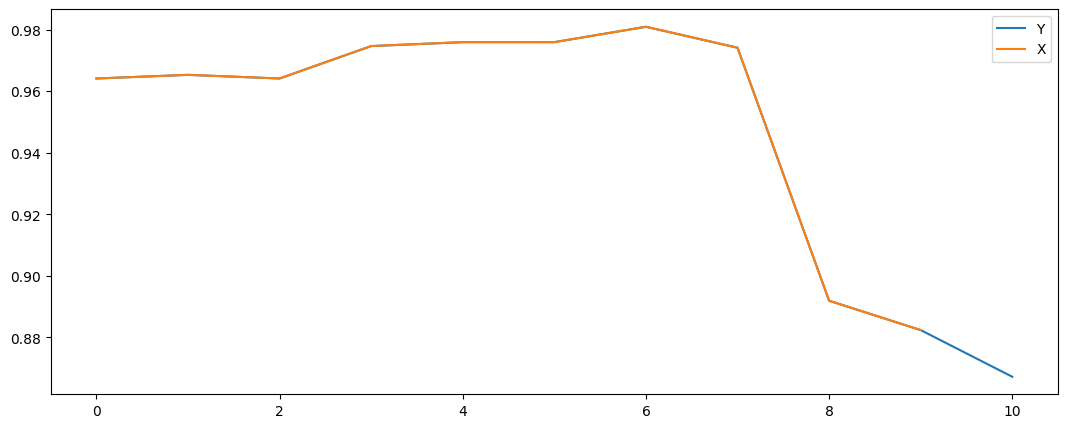

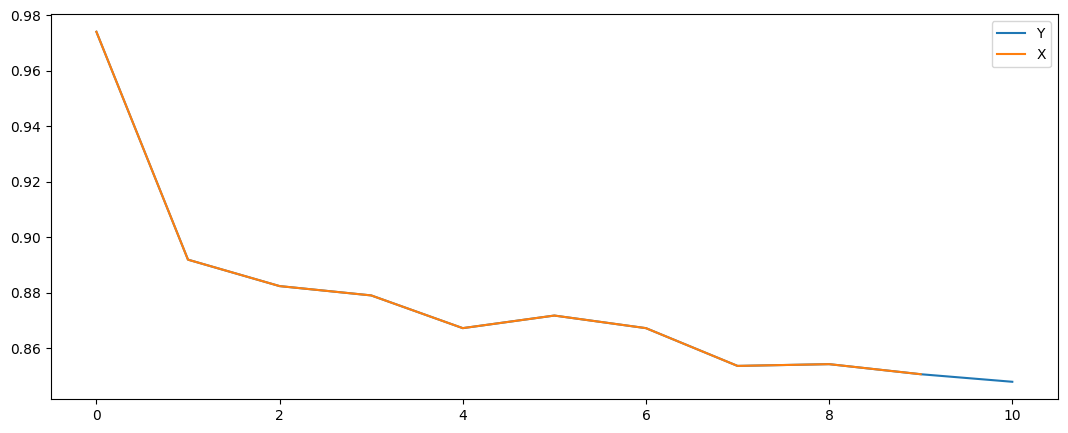

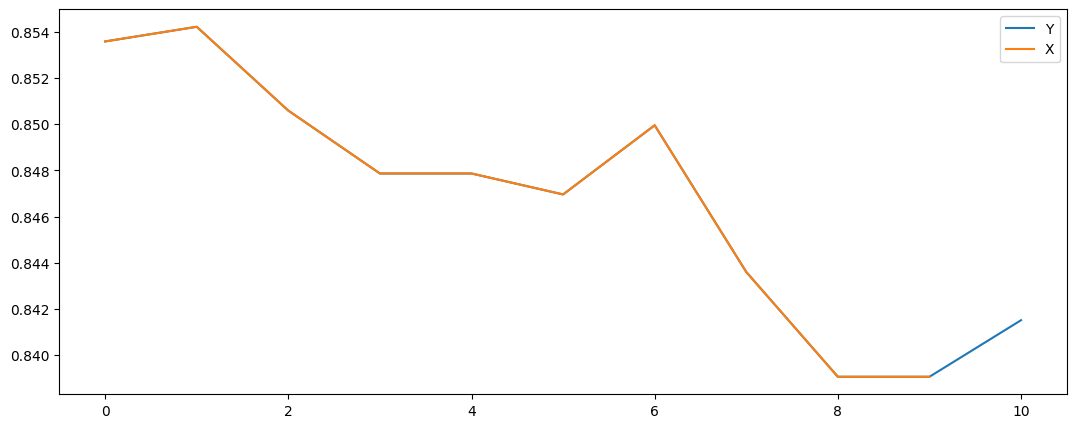

In [127]:
# Plot X and Y
print(X.shape)
for i in range(100,121, 7):
    plot_X, plot_all = [], []
    for value in range(X.shape[1]):
      plot_X.append(X[i, value, target_column_index])
      plot_all.append(X[i, value, target_column_index])
    plot_all.append(Y[i, target_column_index])

    plt.figure(figsize=(13, 5))
    plt.plot(plot_all, label='Y')
    plt.plot(plot_X, label='X')
    plt.legend()
    plt.show()

In [128]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1392, 10, 10) (1392, 10)
(597, 10, 10) (597, 10)


In [129]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], feature_number)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\orhun\.conda\envs\stockprice\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [130]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=1, verbose=1)

Epoch 1/5
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0207 - val_loss: 0.0122
Epoch 2/5
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0175 - val_loss: 0.0113
Epoch 3/5
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0183 - val_loss: 0.0113
Epoch 4/5
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0189 - val_loss: 0.0113
Epoch 5/5
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0185 - val_loss: 0.0114


dict_keys(['loss', 'val_loss'])


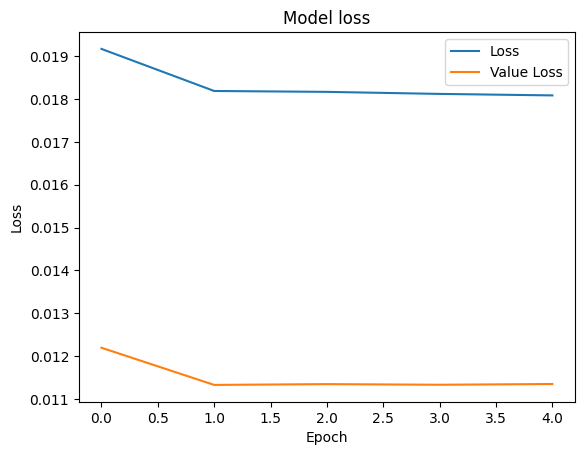

In [135]:
# Plot training & validation loss values
print(history.history.keys())
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Value Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [199]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [200]:
print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")
print(train_predict[:2, :])

train_predict.shape=(1392, 1), test_predict.shape=(597, 1), Y_train.shape=(1392, 10), Y_test.shape=(597, 10)
[[0.8520108]
 [0.8548462]]


In [235]:
# Inverse transform the predictions
def update_data_to_inverse(predicted_data: np.ndarray, scaler: MinMaxScaler, target_column_index: int):
    new_dataset = np.zeros(shape=(len(predicted_data), feature_number))
    new_dataset[:,target_column_index] = predicted_data.flatten()
    return scaler.inverse_transform(new_dataset)[:, target_column_index].reshape(-1, 1)

In [236]:
train_predict = update_data_to_inverse(predicted_data=train_predict, scaler=scaler, target_column_index=target_column_index)
test_predict = update_data_to_inverse(predicted_data=test_predict, scaler=scaler, target_column_index=target_column_index)
Y_train = scaler.inverse_transform(Y_train)
Y_test = scaler.inverse_transform(Y_test)

print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")
print(train_predict[:2, :])

train_predict.shape=(1392, 1), test_predict.shape=(597, 1), Y_train.shape=(1392, 10), Y_test.shape=(597, 10)
[[1.33405631]
 [1.3340601 ]]


In [244]:
# Calculate MSE
train_mse = mean_squared_error(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
test_mse = mean_squared_error(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

# Calculate R2 score
train_r2 = r2_score(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
test_r2 = r2_score(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train R2 Score: {train_r2:.4f}, Test R2 Score: {test_r2:.4f}")

Train MSE: 0.0000, Test MSE: 0.0000
Train R2 Score: -704.0662, Test R2 Score: -4631.6635


time_step=10, X.shape=(1989, 10, 10), (len(train_predict) + time_step)=1402
test_predict.shape=(597, 1), train_predict.shape=(1392, 1), scaled_data.shape=(2000, 10)


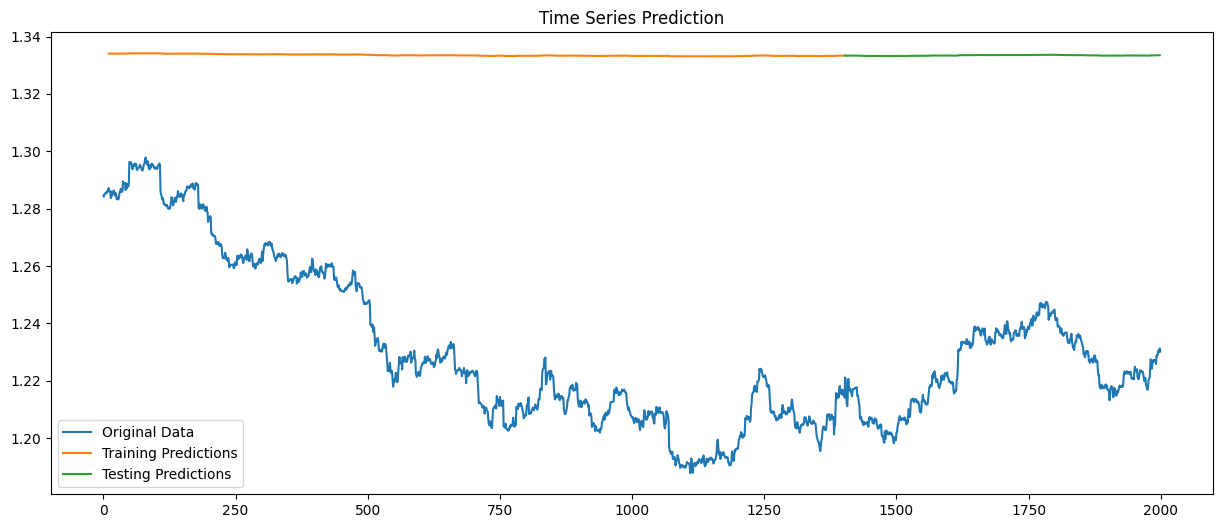

In [245]:
print(f"{time_step=}, {X.shape=}, {(len(train_predict) + time_step)=}")
print(f"{test_predict.shape=}, {train_predict.shape=}, {scaled_data.shape=}")

# Plot the predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data)[:, target_column_index], label='Original Data')
train_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(train_predict_plot, label='Training Predictions')

test_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + time_step:len(scaled_data[:, target_column_index]) - 1, :] = test_predict
plt.plot(test_predict_plot, label='Testing Predictions')

plt.title('Time Series Prediction')
plt.legend()
plt.show()

In [ ]:
model.save('lstm_model_test.h5')

In [ ]:
# # Load the saved model
# loaded_model = load_model('lstm_model.h5')

In [ ]:
# # Assuming `X_new` and `Y_new` are new data arrays
# history_updated = loaded_model.fit(X_new, Y_new, epochs=50, batch_size=1, verbose=1)

# # Save the updated model
# loaded_model.save('updated_lstm_model.h5')